## Fraud Detection in Financial Transactions
### Project - INFS3208
### Dev Gupta (48188665)

#### Import Libraries
#### Start Spark Seesion 
#### Read dataset

To Read dataset using MongoDB- Replace the read data line with the following:

mongo_uri = "mongodb://localhost:27017"

database_name = "FraudData"

collection_name = "Fraud Detection"

read_options = {

    "uri": mongo_uri,

    "database": database_name,

    "collection": collection_name,

}

raw_df = spark.read.format("mongo").options(**read_options).load()

In [14]:
# Import libraries
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import DoubleType
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Start Spark session  
spark = SparkSession.builder.appName('FraudDetection').getOrCreate()

# Read CSV data
raw_df = spark.read.csv('fraudData.csv', header=True)

## Data Cleaning

In this section, we perform data cleaning to remove special characters from various columns. We use the `regexp_replace` function to replace any non-alphanumeric characters with empty strings.
Removing all the irrelevant apostrophes from spark dataset

In [15]:
# Replace non-word characters
raw_df = raw_df.withColumn("customer", regexp_replace("customer", "[^\w\s]", ""))
raw_df = raw_df.withColumn("age", regexp_replace("age", "[^\w\s]", ""))
raw_df = raw_df.withColumn("gender", regexp_replace("gender", "[^\w\s]", ""))
raw_df = raw_df.withColumn("zipcodeOri", regexp_replace("zipcodeOri", "[^\w\s]", ""))
raw_df = raw_df.withColumn("merchant", regexp_replace("merchant", "[^\w\s]", ""))
raw_df = raw_df.withColumn("zipMerchant", regexp_replace("zipMerchant", "[^\w\s]", ""))
raw_df = raw_df.withColumn("category", regexp_replace("category", "[^\w\s]", ""))

#### Data Type Casting in PySpark DataFrame

In this cell, we perform data type casting on columns in a PySpark DataFrame to ensure that each column has the appropriate data type for analysis. 

#### Initial DataFrame

We start with an initial DataFrame `raw_df` that contains columns with various data types. To prepare the data for analysis, we cast specific columns to their intended data types.

#### Data Type Casting

The following columns were cast to their respective data types:

- `step`: Cast to `int`
- `customer`: Cast to `string`
- `age`: Cast to `int`
- `gender`: Cast to `string`
- `zipcodeOri`: Cast to `int`
- `merchant`: Cast to `string`
- `zipMerchant`: Cast to `int`
- `category`: Cast to `string`
- `amount`: Cast to `double`
- `fraud`: Cast to `string`

This casting ensures that the DataFrame is ready for further analysis and processing.

Data type casting is an essential step in data preparation, as it ensures that the data is in the correct format for subsequent analysis, visualization, or machine learning tasks.



In [16]:
# Cast columns to appropriate types
raw_df = raw_df.withColumn("step", raw_df["step"].cast("int"))
raw_df = raw_df.withColumn("customer", raw_df["customer"].cast("string"))
raw_df = raw_df.withColumn("age", raw_df["age"].cast("int"))
raw_df = raw_df.withColumn("gender", raw_df["gender"].cast("string"))
raw_df = raw_df.withColumn("zipcodeOri", raw_df["zipcodeOri"].cast("int"))
raw_df = raw_df.withColumn("merchant", raw_df["merchant"].cast("string"))
raw_df = raw_df.withColumn("zipMerchant", raw_df["zipMerchant"].cast("int"))
raw_df = raw_df.withColumn("category", raw_df["category"].cast("string"))
raw_df = raw_df.withColumn("amount", raw_df["amount"].cast(DoubleType()))
raw_df = raw_df.withColumn("fraud", raw_df["fraud"].cast("string"))

#### Exploring Data
In this cell, we perform data cleaning and provide a summary of the cleaned dataset. We first remove rows with missing values in specific columns, including 'amount,' 'fraud,' 'step,' 'age,' 'zipcodeOri,' and 'zipMerchant.' After cleaning, we display summary statistics for the dataset using the `describe()` function. This summary includes statistics like count, mean, standard deviation, minimum, and maximum for each numerical column.

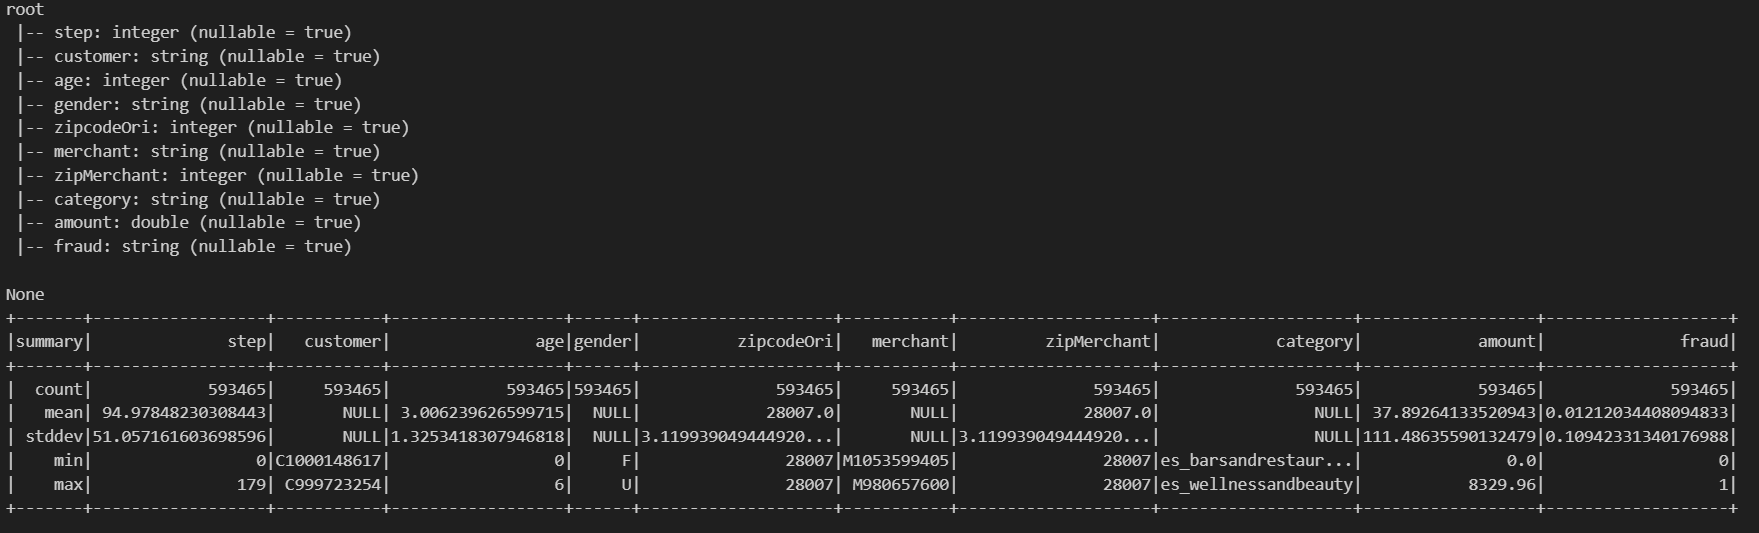

This cell also displays the distribution of the 'fraud' column in the cleaned dataset. We group the data by the 'fraud' column and count the number of occurrences of each unique value (0 or 1). This helps us understand how the instances are distributed between fraudulent (1) and non-fraudulent (0) transactions in the dataset.

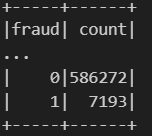


In [17]:
# Explore data  
print(raw_df.printSchema())
raw_df_cleaned = raw_df.dropna(subset=['amount', 'fraud','step','age','zipcodeOri','zipMerchant'])
raw_df_cleaned.describe().show()
raw_df_cleaned.groupby('fraud').count().show()


root
 |-- step: integer (nullable = true)
 |-- customer: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- zipcodeOri: integer (nullable = true)
 |-- merchant: string (nullable = true)
 |-- zipMerchant: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- fraud: string (nullable = true)

None
+-------+------------------+-----------+------------------+------+--------------------+-----------+--------------------+--------------------+------------------+-------------------+
|summary|              step|   customer|               age|gender|          zipcodeOri|   merchant|         zipMerchant|            category|            amount|              fraud|
+-------+------------------+-----------+------------------+------+--------------------+-----------+--------------------+--------------------+------------------+-------------------+
|  count|            593465|     593465|            5

#### Visualize Transaction Amount Distribution

In this section, we'll visualize the distribution of transaction amounts in the dataset. Understanding the distribution of transaction amounts is crucial in fraud detection and data analysis.

We create a histogram to visualize the frequency of different transaction amounts:

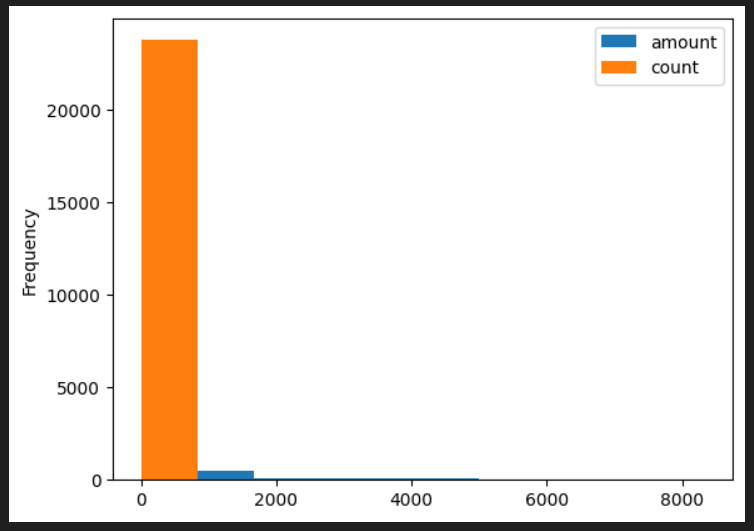


<Axes: ylabel='Frequency'>

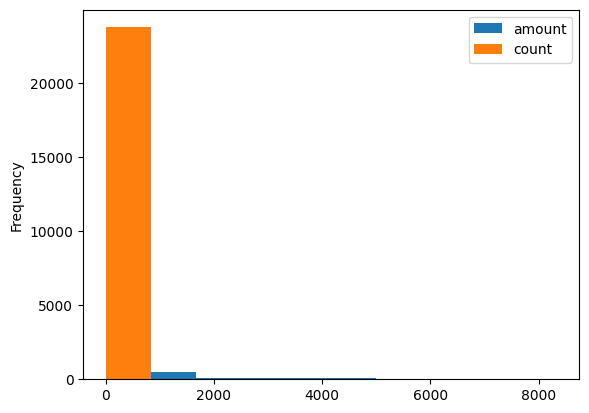

In [18]:
# Visualize transaction amount distribution
amounts = raw_df_cleaned.groupBy('amount').count().toPandas()
amounts.plot(kind='hist')

### Data Exploration and Filtering

In this section, we'll explore the data and apply various filters to create specific subsets of the dataset. We'll use Spark SQL to perform these operations.

#### Initial Data Overview

We start by taking an initial look at the data after cleaning:

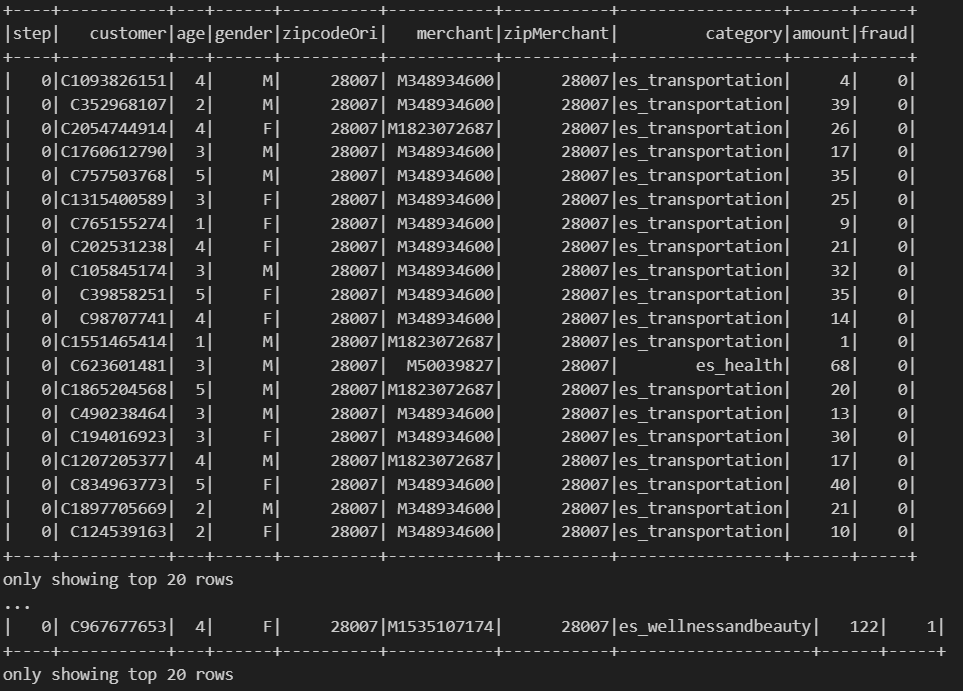

#### Filter by Step
We can filter the data based on the step value. For example, to select records where step is equal to 10:

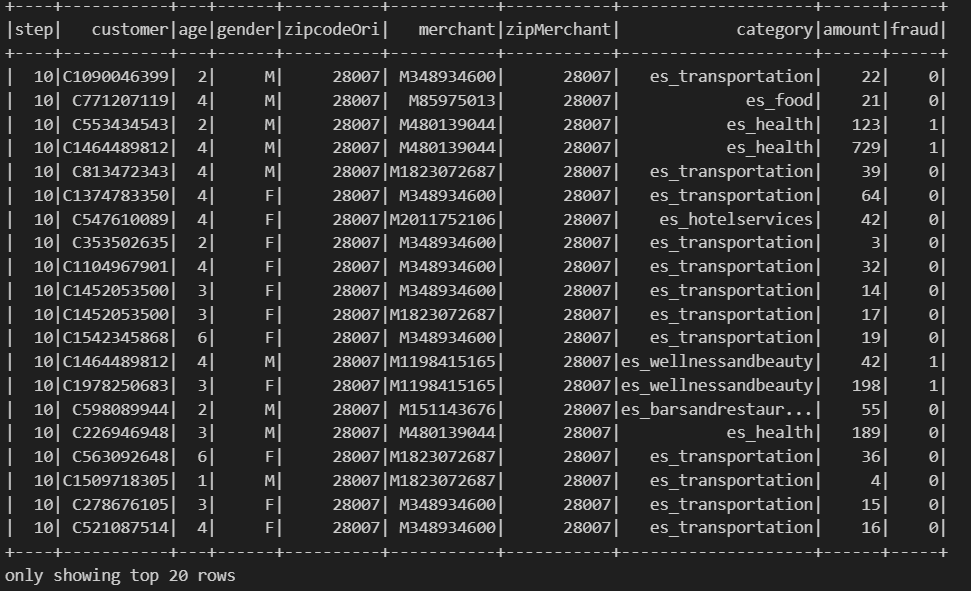

#### Filter by Category
Next, we can filter by the "category" column. Let's select records where the category is either 'es_transport' or 'es_health':

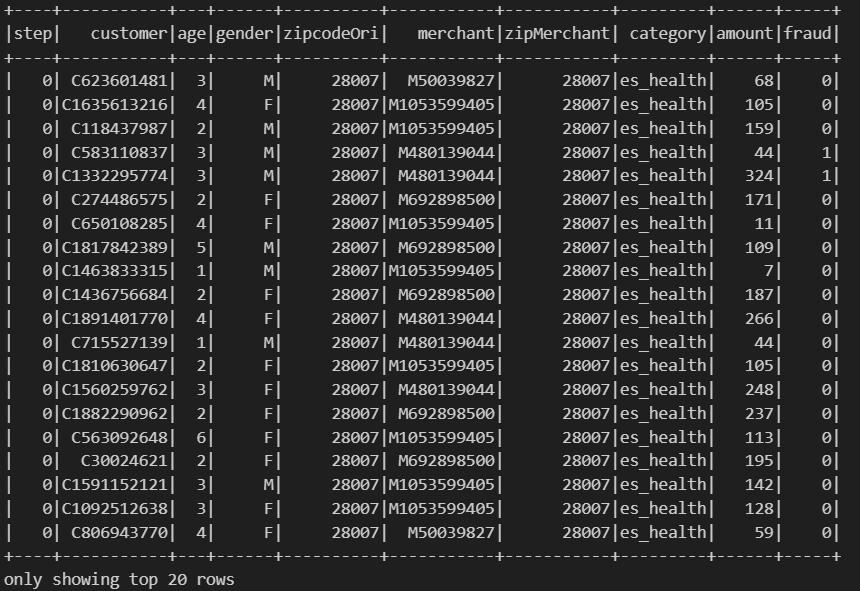

#### Filter by Step Range
We can filter records within a specific step range. For example, to select records where the step is between 100 and 150:

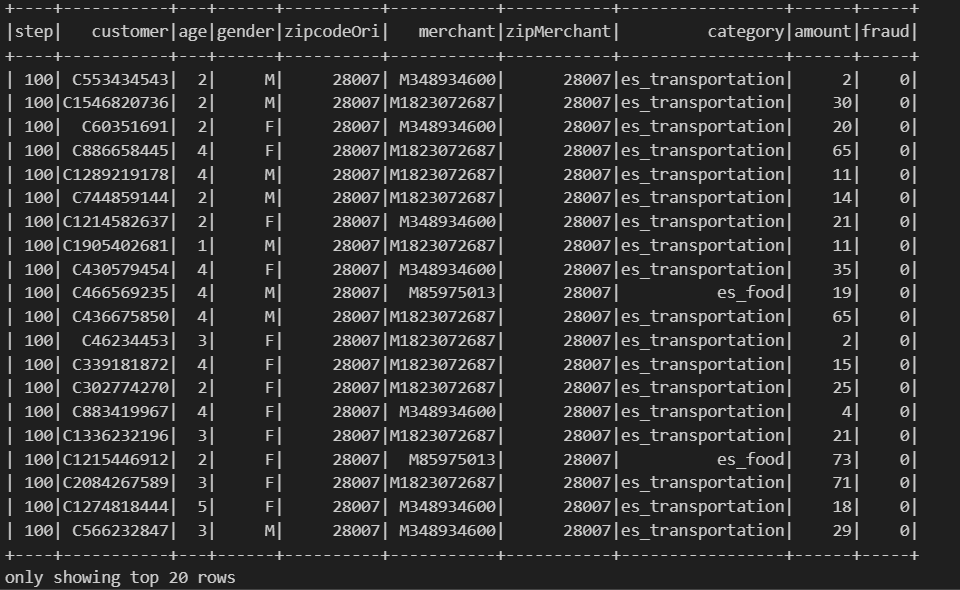

#### Filter by Gender
Filtering by the "gender" column, let's select records where the gender is 'F':

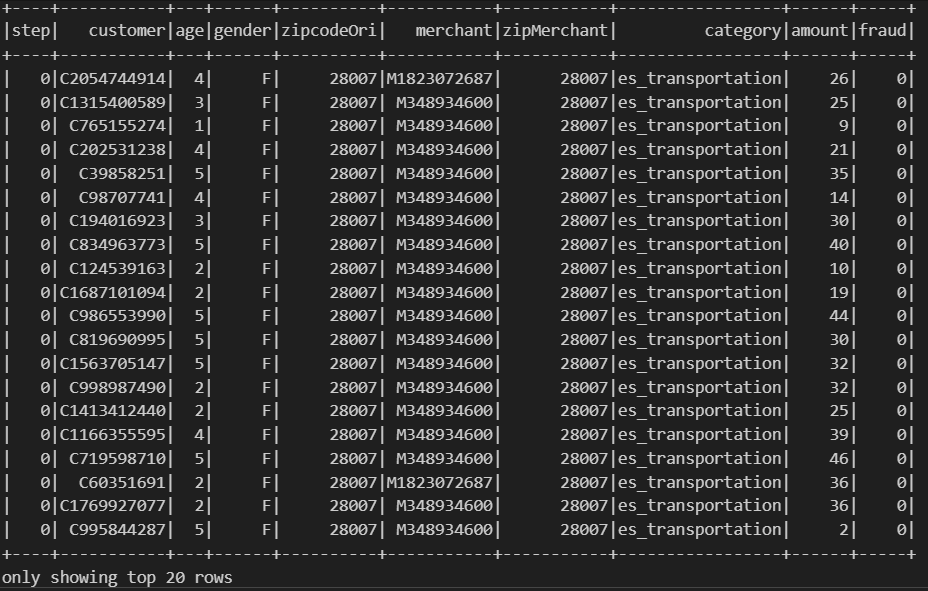

#### Filter by Amount and Fraud
We can filter by both the "amount" and "fraud" columns. To select records where the amount is greater than 50 and fraud is 1:

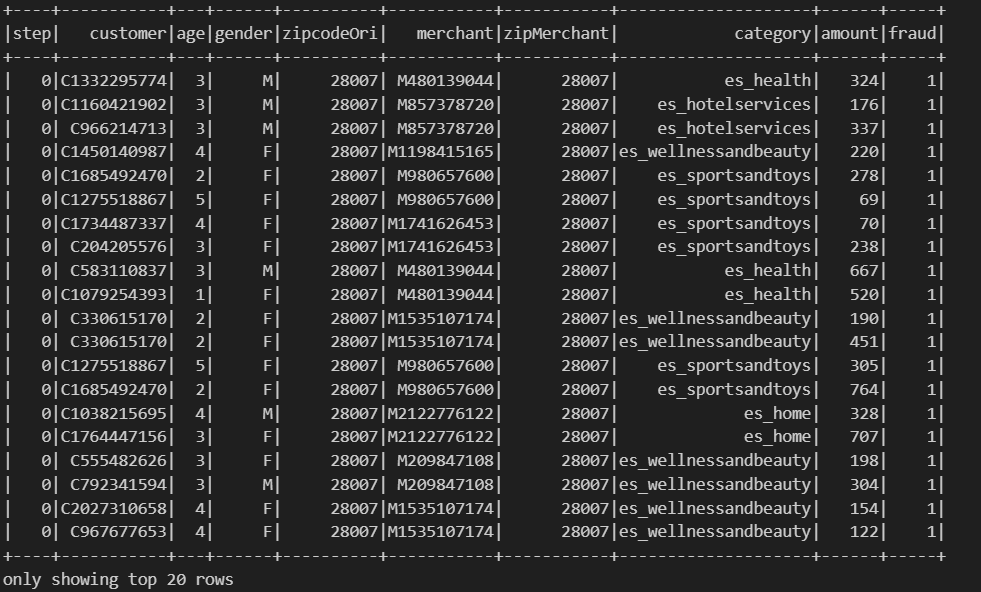

In [19]:
raw_df_cleaned.createOrReplaceTempView("transactions")


# Perform feature engineering using Spark SQL
engineered_df = spark.sql("""
    SELECT
       CAST(step AS INT) AS step,
        customer,
        age,
        gender,
        zipcodeOri,
        merchant,
        zipMerchant,
        category,
       CAST(amount AS INT) AS amount,
       CAST(fraud AS INT) AS fraud
    FROM transactions
""")

# Show the resulting DataFrame
engineered_df.show()

filtered_df = engineered_df.filter(
    (engineered_df.step == 10))
filtered_df.show()

filtered_df = engineered_df.filter(
    (engineered_df.category.isin('es_transport', 'es_health')))
filtered_df.show()

filtered_df = engineered_df.filter(
    ((engineered_df.step >= 100) & (engineered_df.step <= 150)))
filtered_df.show()

filtered_df = engineered_df.filter(
    (engineered_df.gender == 'F') )
filtered_df.show()

filtered_df = engineered_df.filter(
   ((engineered_df.amount > 50) & (engineered_df.fraud == 1)))
filtered_df.show()


+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+
|step|   customer|age|gender|zipcodeOri|   merchant|zipMerchant|         category|amount|fraud|
+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+
|   0|C1093826151|  4|     M|     28007| M348934600|      28007|es_transportation|     4|    0|
|   0| C352968107|  2|     M|     28007| M348934600|      28007|es_transportation|    39|    0|
|   0|C2054744914|  4|     F|     28007|M1823072687|      28007|es_transportation|    26|    0|
|   0|C1760612790|  3|     M|     28007| M348934600|      28007|es_transportation|    17|    0|
|   0| C757503768|  5|     M|     28007| M348934600|      28007|es_transportation|    35|    0|
|   0|C1315400589|  3|     F|     28007| M348934600|      28007|es_transportation|    25|    0|
|   0| C765155274|  1|     F|     28007| M348934600|      28007|es_transportation|     9|    0|
|   0| C202531238|  4|     F|     28007|

#### Train/Validation/Test Split

We begin by splitting our dataset into training, validation, and test sets. This is a Important in machine learning to assess the performance of our models. In this case, we split the data into the following proportions:
- 70% for training
- 20% for validation
- 10% for testing

#### Data Type Conversion
Next, we perform data type conversion on certain columns in our dataset to ensure they have the correct data types. Specifically, we make the following conversions:

- Convert the "step" column to integer type.
- Convert the "amount" column to double type.
- Convert the "fraud" column to integer type.



In [20]:
# Train/val/test split
(train, val, test) = engineered_df.randomSplit([0.7, 0.2, 0.1])

engineered_df = engineered_df.withColumn("step", engineered_df["step"].cast("int"))
engineered_df = engineered_df.withColumn("amount", engineered_df["amount"].cast('double'))
engineered_df = engineered_df.withColumn("fraud", engineered_df["fraud"].cast("int"))

#### Regression - Linear Regression
In this section, we are performing a linear regression analysis on the dataset. We select specific columns, create feature vectors, and train a linear regression model.

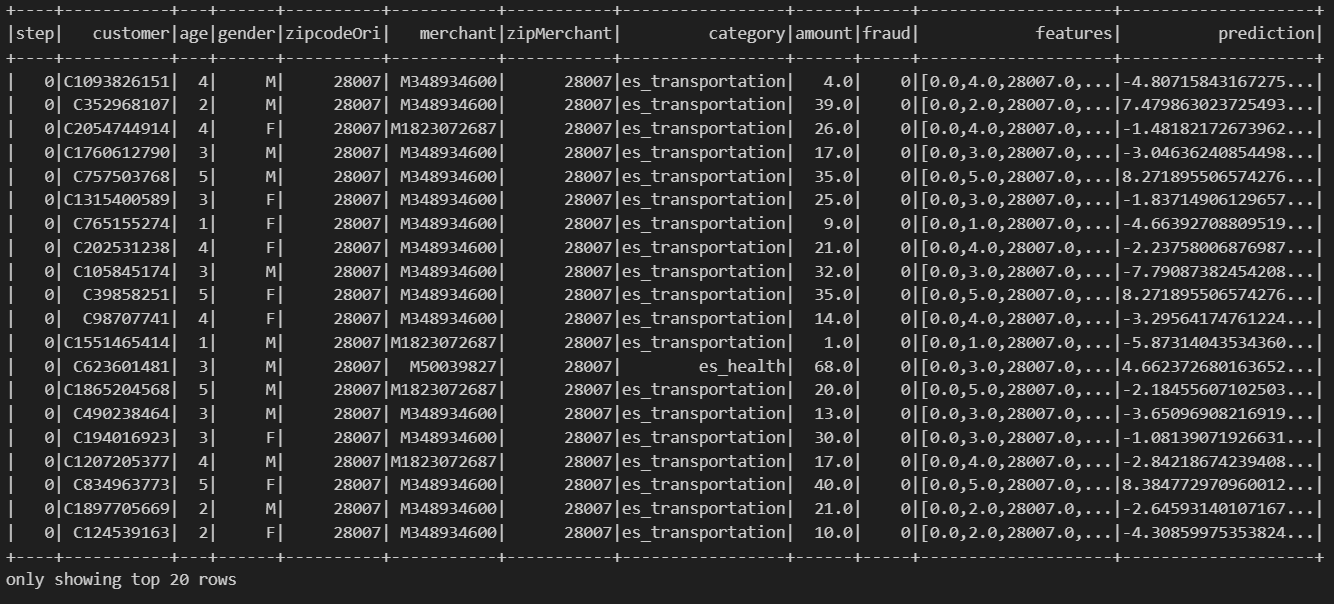


After fitting the model, we visualize the actual vs. predicted fraud values using a scatter plot:

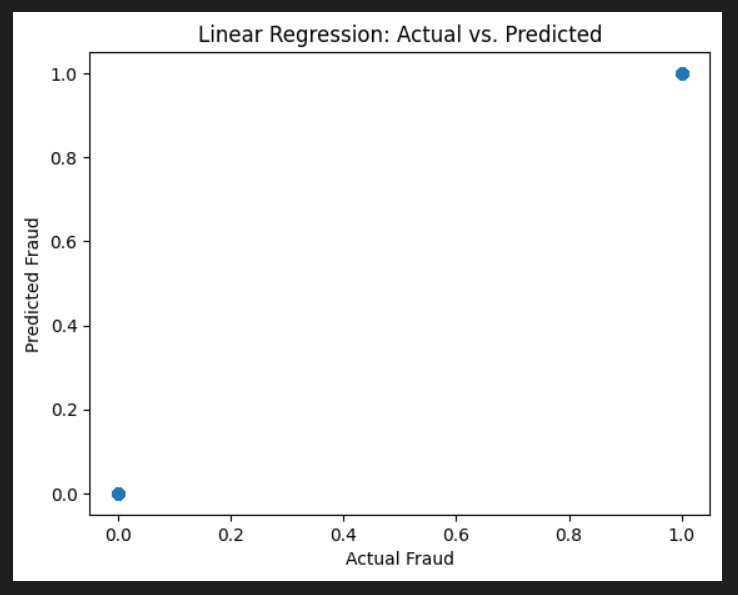

### Clustering - K-means
In this section, we perform K-means clustering on the dataset using the selected columns. We then visualize the results.

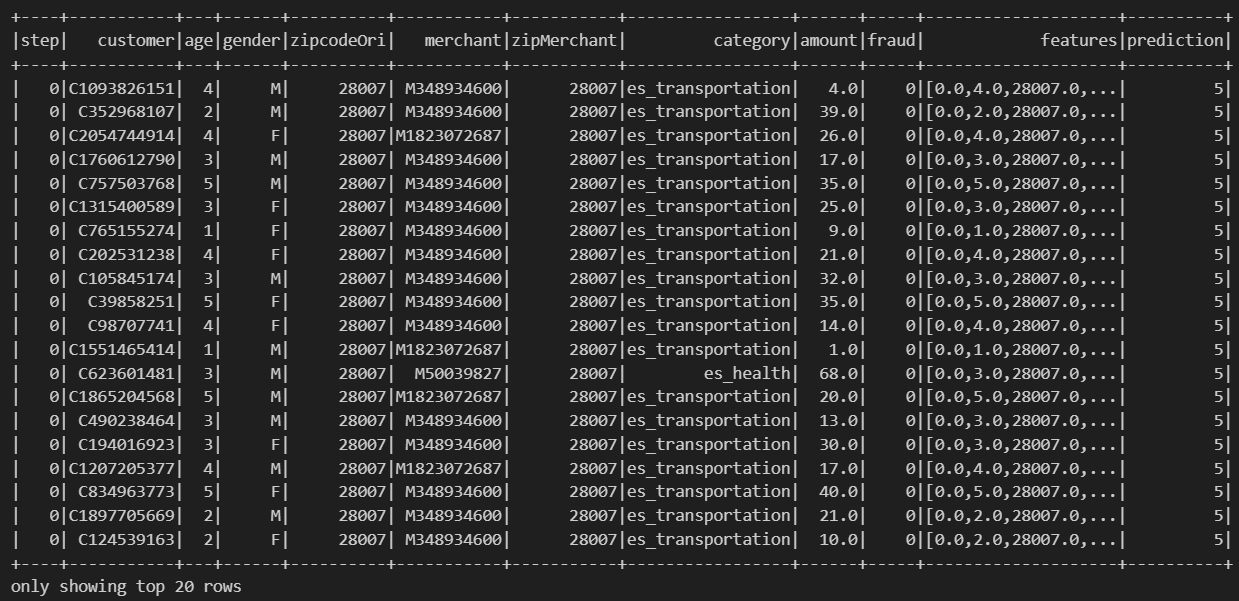

The clustering results are visualized in a scatter plot, where each point is color-coded based on the cluster it belongs to.

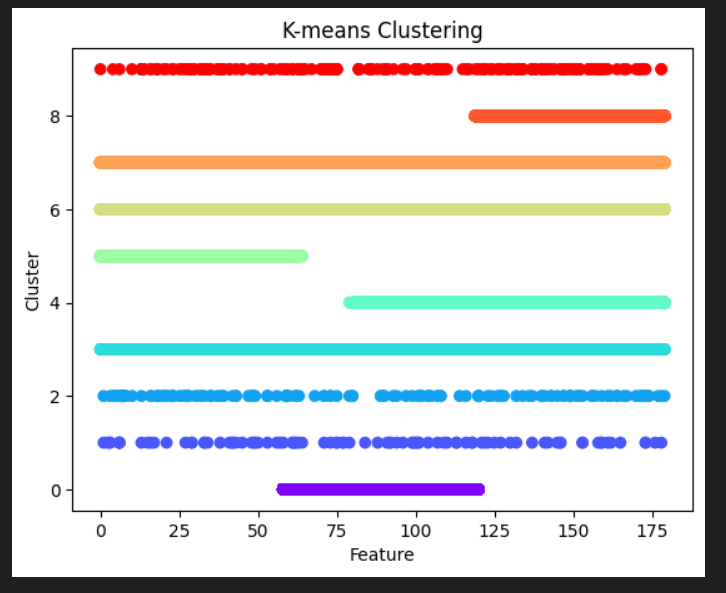



+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+--------------------+--------------------+
|step|   customer|age|gender|zipcodeOri|   merchant|zipMerchant|         category|amount|fraud|            features|          prediction|
+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+--------------------+--------------------+
|   0|C1093826151|  4|     M|     28007| M348934600|      28007|es_transportation|   4.0|    0|[0.0,4.0,28007.0,...|-4.80715843167275...|
|   0| C352968107|  2|     M|     28007| M348934600|      28007|es_transportation|  39.0|    0|[0.0,2.0,28007.0,...|7.479863023725493...|
|   0|C2054744914|  4|     F|     28007|M1823072687|      28007|es_transportation|  26.0|    0|[0.0,4.0,28007.0,...|-1.48182172673962...|
|   0|C1760612790|  3|     M|     28007| M348934600|      28007|es_transportation|  17.0|    0|[0.0,3.0,28007.0,...|-3.04636240854498...|
|   0| C757503768|  5|     M|     

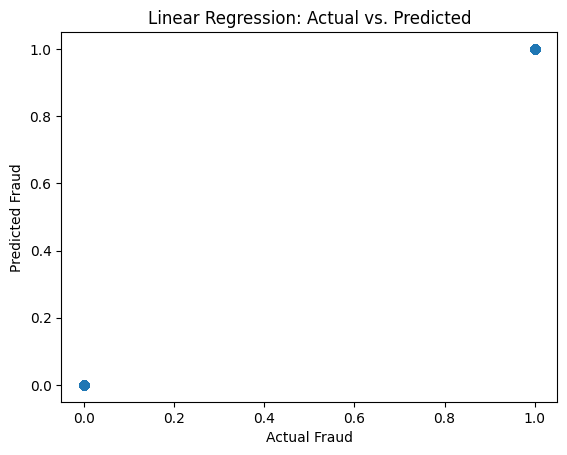

+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+--------------------+----------+
|step|   customer|age|gender|zipcodeOri|   merchant|zipMerchant|         category|amount|fraud|            features|prediction|
+----+-----------+---+------+----------+-----------+-----------+-----------------+------+-----+--------------------+----------+
|   0|C1093826151|  4|     M|     28007| M348934600|      28007|es_transportation|   4.0|    0|[0.0,4.0,28007.0,...|         5|
|   0| C352968107|  2|     M|     28007| M348934600|      28007|es_transportation|  39.0|    0|[0.0,2.0,28007.0,...|         5|
|   0|C2054744914|  4|     F|     28007|M1823072687|      28007|es_transportation|  26.0|    0|[0.0,4.0,28007.0,...|         5|
|   0|C1760612790|  3|     M|     28007| M348934600|      28007|es_transportation|  17.0|    0|[0.0,3.0,28007.0,...|         5|
|   0| C757503768|  5|     M|     28007| M348934600|      28007|es_transportation|  35.0|    0|[0.0,5.0,

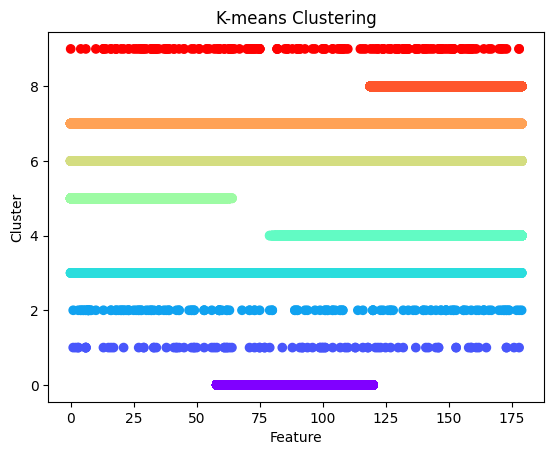

In [21]:
# Regression - Linear regression
from pyspark.ml.regression import LinearRegression

custom_columns = ["step","age", "zipcodeOri", "zipMerchant", "amount","fraud"]
assembler = VectorAssembler(inputCols=custom_columns, outputCol="features")
test_set = assembler.transform(engineered_df)

lr = LinearRegression(featuresCol="features",labelCol="fraud")
model = lr.fit(test_set)
predictions = model.transform(test_set)
predictions.show()

actual_values = [row.fraud for row in predictions.select("fraud").collect()]
predicted_values = [row.prediction for row in predictions.select("prediction").collect()]

plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel("Actual Fraud")
plt.ylabel("Predicted Fraud")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()


# Clustering - K-means
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(10).setSeed(1) 
model = kmeans.fit(test_set)
predictions = model.transform(test_set)
predictions.show()

clustered_data = predictions.select("features", "prediction").toPandas()
features = clustered_data["features"].apply(lambda x: x[0])
predictions = clustered_data["prediction"]

# Create a scatter plot
plt.scatter(features, predictions, c=predictions, cmap="rainbow")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.title("K-means Clustering")
plt.show()


## Data Preprocessing

In this section, we'll perform data preprocessing steps to prepare the data for model training.

### Feature Selection

We've selected the following features for our analysis:
- `step`: The time step of the transaction.
- `age`: The age of the customer.
- `zipcodeOri`: The original zipcode.
- `zipMerchant`: The zipcode of the merchant.
- `amount`: The transaction amount.
- `fraud`: The target variable indicating fraud (1 for fraud, 0 for non-fraud).

### Data Transformation

We use the `VectorAssembler` from Spark ML to transform the selected features into a single feature vector.


In [22]:
custom_columns = ["step","age", "zipcodeOri", "zipMerchant", "amount","fraud"]
assembler = VectorAssembler(inputCols=custom_columns, outputCol="features")
train_set = assembler.transform(train) 
val_set = assembler.transform(val)
test_set = assembler.transform(test)

In [23]:
# Convert PySpark DataFrames to Pandas DataFrames
train_df = train_set.select('amount', 'fraud','step').toPandas()
val_df = val_set.select('amount', 'fraud','step').toPandas()
test_df = test_set.select('amount', 'fraud','step').toPandas()

## Data Preparation for Logistic Regression

In this section, we prepare the data for logistic regression. 

We split the dataset into training, validation, and test sets, and extract the features (X) and target (y) variables.



In [24]:
# Prepare data for logistic regression
X_train = train_df.drop('fraud', axis=1)
y_train = train_df['fraud']

X_val = val_df.drop('fraud', axis=1)
y_val = val_df['fraud']

X_test = test_df.drop('fraud', axis=1)
y_test = test_df['fraud']

# Logistic Regression

Logistic Regression is a statistical model used for binary classification problems. It estimates the probability of a binary outcome based on one or more predictor variables. Despite its name, logistic regression is a classification algorithm. It models the relationship between the independent variables and the probability of a particular outcome using the logistic function (also known as the sigmoid function). The output of logistic regression is a probability score that can be interpreted as the likelihood of the binary outcome. It's a simple yet powerful algorithm, and it's widely used in various fields, including healthcare, finance, and social sciences.

We trained a logistic regression model using the following code

### Validation Predictions
We made predictions on the validation set using the logistic regression model. These predictions can be evaluated to assess the model's performance.


In [25]:
# Create and train a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = logistic_model.predict(X_val)

# Model Evaluation Metrics for Validation Set

After training and making predictions on the validation set, it's essential to evaluate the model's performance using various metrics. Below are some of the key evaluation metrics for the validation set:

### Accuracy
Accuracy is a measure of how many predictions were correct compared to the total number of samples in the validation set. It provides an overall assessment of the model's correctness.



### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model. It breaks down the predictions into four categories: true positives, true negatives, false positives, and false negatives.

Here's the confusion matrix for the validation set:

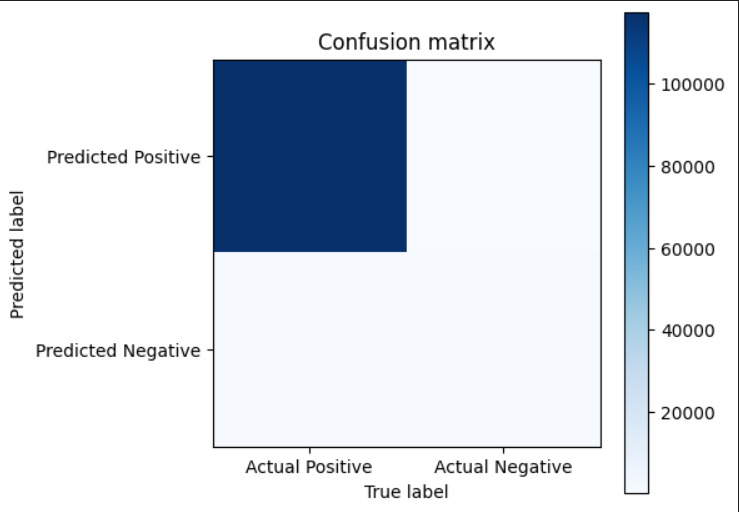

### Classification Report
The classification report provides a detailed summary of various classification metrics, including precision, recall, F1-score, and support for each class.

Here's the classification report for the validation set:

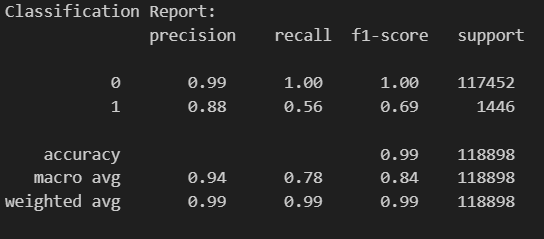

- Precision: Precision measures the accuracy of positive predictions. It is the ratio of true positives to the sum of true positives and false positives.

- Recall: Recall measures the model's ability to find all relevant instances. It is the ratio of true positives to the sum of true positives and false negatives.

- F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balanced evaluation metric.

- Support: Support is the number of actual occurrences of the class in the validation dataset.

These evaluation metrics help in understanding the model's strengths and weaknesses. It's important to analyze these metrics to make informed decisions and fine-tune the model for better performance.



In [26]:
# Model evaluation metrics for validation set
accuracy = accuracy_score(y_val, y_val_pred)
cm = confusion_matrix(y_val, y_val_pred)
classification = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', classification)

Validation Accuracy: 99.37%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    117054
           1       0.87      0.57      0.69      1459

    accuracy                           0.99    118513
   macro avg       0.93      0.79      0.84    118513
weighted avg       0.99      0.99      0.99    118513



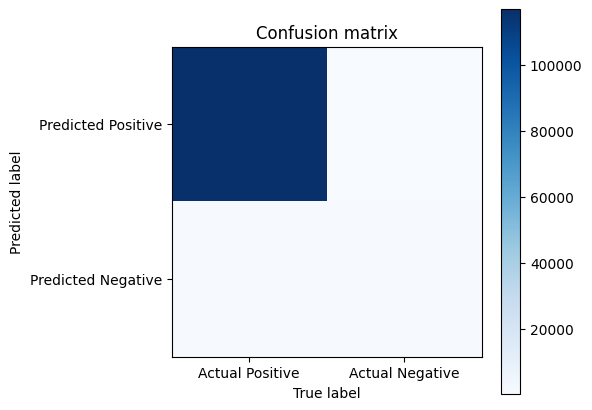

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
ticks = range(2)
plt.xticks(ticks, ['Actual Positive', 'Actual Negative'])  
plt.yticks(ticks, ['Predicted Positive', 'Predicted Negative'])
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

# Model Evaluation Metrics for Test Set

After training and making predictions on the test set, it's essential to evaluate the model's performance using various metrics. Below are some of the key evaluation metrics for the test set:

### Accuracy
Accuracy is a measure of how many predictions were correct compared to the total number of samples in the validation set. It provides an overall assessment of the model's correctness.



### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model. It breaks down the predictions into four categories: true positives, true negatives, false positives, and false negatives.

Here's the confusion matrix for the test set:

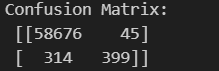


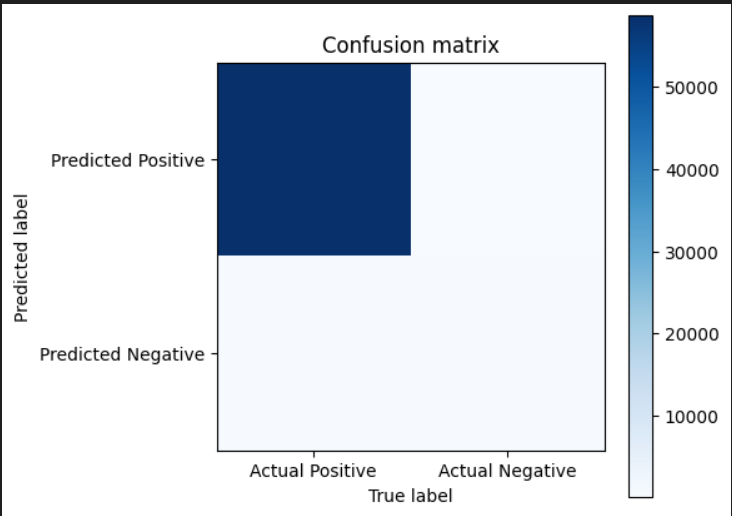


### Classification Report
The classification report provides a detailed summary of various classification metrics, including precision, recall, F1-score, and support for each class.

Here's the classification report for the test set:

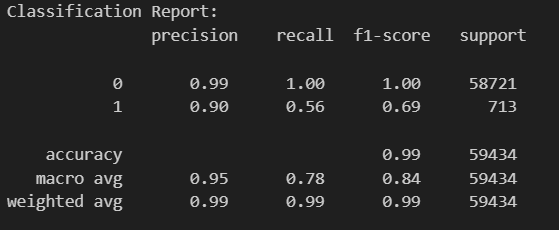

- Precision: Precision measures the accuracy of positive predictions. It is the ratio of true positives to the sum of true positives and false positives.

- Recall: Recall measures the model's ability to find all relevant instances. It is the ratio of true positives to the sum of true positives and false negatives.

- F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balanced evaluation metric.

- Support: Support is the number of actual occurrences of the class in the validation dataset.

These evaluation metrics help in understanding the model's strengths and weaknesses. It's important to analyze these metrics to make informed decisions and fine-tune the model for better performance.



In [28]:
# Predictions on the test set
y_test_pred = logistic_model.predict(X_test)

# Model evaluation metrics for test set
accuracy = accuracy_score(y_test, y_test_pred)
confusion = confusion_matrix(y_test, y_test_pred)
classification = classification_report(y_test, y_test_pred)

print('Test Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification)

Test Accuracy: 0.9935270158359952
Confusion Matrix:
 [[58409    51]
 [  332   377]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     58460
           1       0.88      0.53      0.66       709

    accuracy                           0.99     59169
   macro avg       0.94      0.77      0.83     59169
weighted avg       0.99      0.99      0.99     59169



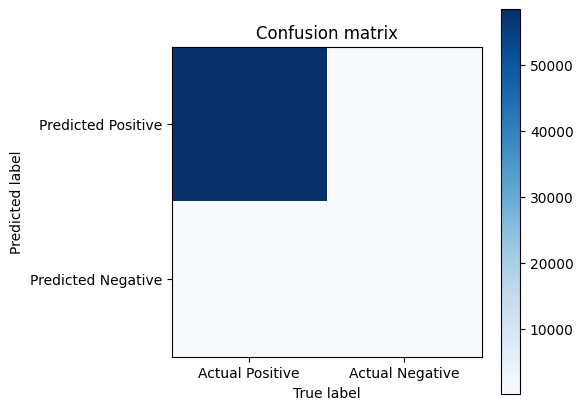

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
ticks = range(2)
plt.xticks(ticks, ['Actual Positive', 'Actual Negative'])  
plt.yticks(ticks, ['Predicted Positive', 'Predicted Negative'])
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

# Decision Tree

A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It is a graphical representation of a decision-making process, where each internal node represents a feature (attribute), each branch represents a decision rule, and each leaf node represents an outcome. The decision tree algorithm recursively splits the dataset into subsets based on the most significant attribute, creating a tree-like structure. It's interpretable, easy to visualize, and can handle both categorical and numerical data. Decision Trees are prone to overfitting, but techniques like pruning can help mitigate this issue.



We trained a decision tree model using the following code

## Model Evaluation Metrics for Decision Tree Model

After training and making predictions on the model, it's essential to evaluate the model's performance using various metrics. Below are some of the key evaluation metrics for the model:

### Accuracy
Accuracy is a measure of how many predictions were correct compared to the total number of samples in the validation set. It provides an overall assessment of the model's correctness.

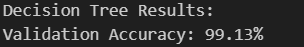

### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model. It breaks down the predictions into four categories: true positives, true negatives, false positives, and false negatives.

Here's the confusion matrix for the model:

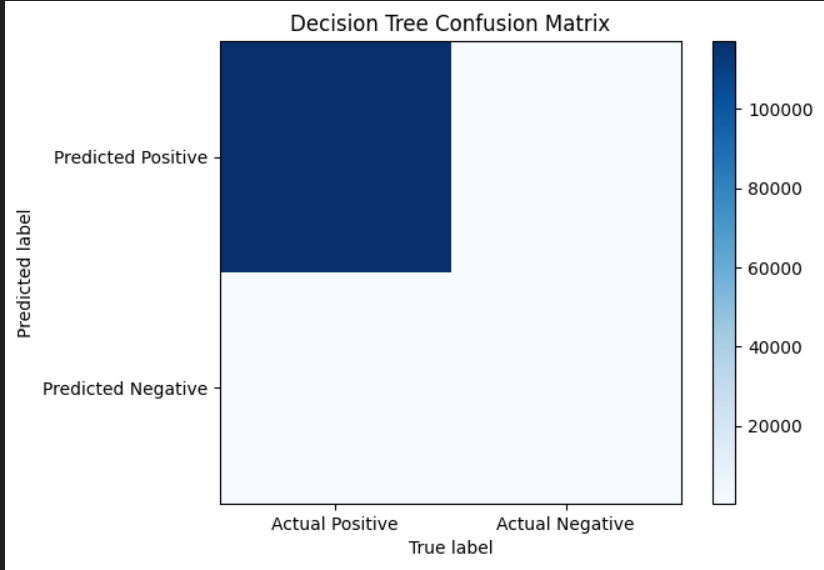


### Classification Report
The classification report provides a detailed summary of various classification metrics, including precision, recall, F1-score, and support for each class.

Here's the classification report for the model:

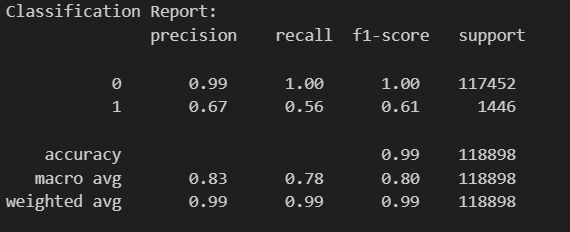

- Precision: Precision measures the accuracy of positive predictions. It is the ratio of true positives to the sum of true positives and false positives.

- Recall: Recall measures the model's ability to find all relevant instances. It is the ratio of true positives to the sum of true positives and false negatives.

- F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balanced evaluation metric.

- Support: Support is the number of actual occurrences of the class in the validation dataset.

These evaluation metrics help in understanding the model's strengths and weaknesses. It's important to analyze these metrics to make informed decisions and fine-tune the model for better performance.



Decision Tree Results:
Validation Accuracy: 99.13%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    117054
           1       0.68      0.56      0.61      1459

    accuracy                           0.99    118513
   macro avg       0.84      0.78      0.80    118513
weighted avg       0.99      0.99      0.99    118513



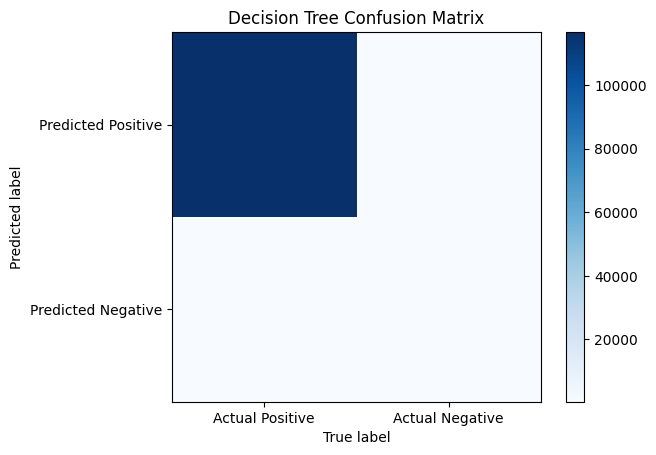

In [30]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=0)
decision_tree_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred_dt = decision_tree_model.predict(X_val)
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
classification_dt = classification_report(y_val, y_val_pred_dt)

print('Decision Tree Results:')
print(f'Validation Accuracy: {accuracy_dt * 100:.2f}%')
print('Classification Report:\n', classification_dt)

def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = range(2)
    plt.xticks(ticks, ['Actual Positive', 'Actual Negative'])  
    plt.yticks(ticks, ['Predicted Positive', 'Predicted Negative'])
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

# Confusion Matrix for Decision Tree
plot_confusion_matrix(cm_dt, 'Decision Tree Confusion Matrix')
plt.show()

# Random Forest

Random Forest is an ensemble learning technique that combines multiple decision trees to improve predictive accuracy and reduce overfitting. It works by creating a forest of decision trees and aggregating their predictions to make a final decision. Each tree in the forest is trained on a subset of the data and uses bootstrapping (sampling with replacement). Random Forest provides feature importance scores, making it a valuable tool for feature selection. It is known for its robustness and ability to handle high-dimensional data.


We trained a Random forest model using the following code

## Model Evaluation Metrics for Random Forest Model

### Accuracy
Accuracy is a measure of how many predictions were correct compared to the total number of samples in the validation set. It provides an overall assessment of the model's correctness.

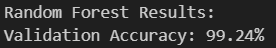


### Classification Report
The classification report provides a detailed summary of various classification metrics, including precision, recall, F1-score, and support for each class.

Here's the classification report for the model:

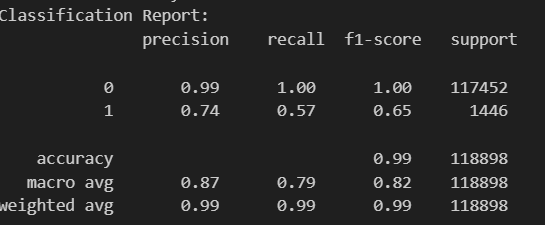



In [31]:
# Random Forest
random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred_rf = random_forest_model.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
classification_rf = classification_report(y_val, y_val_pred_rf)

print('Random Forest Results:')
print(f'Validation Accuracy: {accuracy_rf * 100:.2f}%')
print('Classification Report:\n', classification_rf)

Random Forest Results:
Validation Accuracy: 99.25%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    117054
           1       0.76      0.58      0.66      1459

    accuracy                           0.99    118513
   macro avg       0.88      0.79      0.83    118513
weighted avg       0.99      0.99      0.99    118513



### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model. It breaks down the predictions into four categories: true positives, true negatives, false positives, and false negatives.

Here's the confusion matrix for the model:

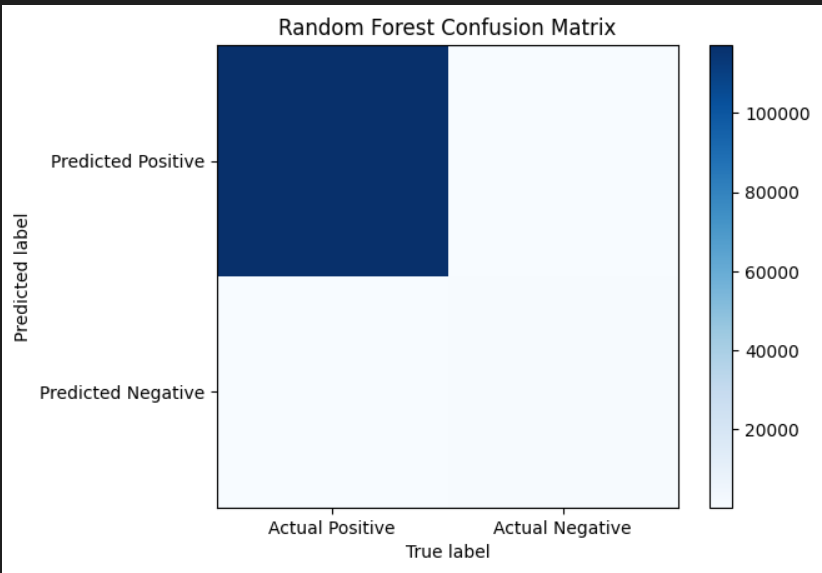

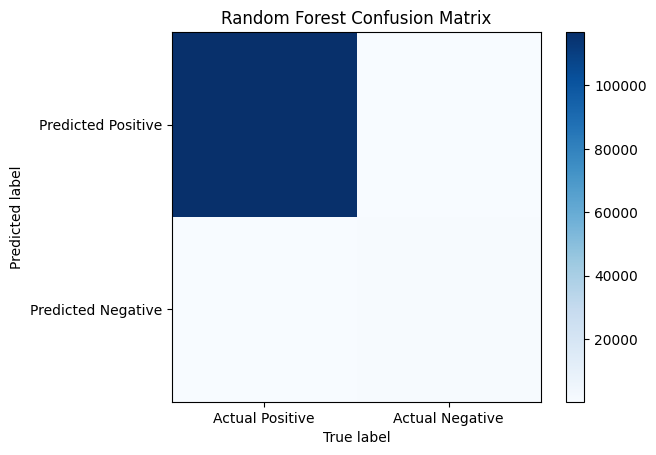

In [32]:
# Confusion Matrix for Random Forest
plot_confusion_matrix(cm_rf, 'Random Forest Confusion Matrix')
plt.show()